# KNN

In [49]:
# Veri işleme kütüphaneleri
import pandas as pd
import numpy as np

# Grafik çizimi için
import matplotlib.pyplot as plt
import seaborn as sns

# Makine öğrenmesi araçları
from sklearn.model_selection import train_test_split #Veriyi eğitim/test olarak ayırır.
from sklearn.preprocessing import StandardScaler #Özellikleri aynı ölçeğe getirir.
from sklearn.neighbors import KNeighborsClassifier #KNN algoritması.
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
#modelin başarımı için kullanılan metrikler.

id: Hasta numarası (model için gereksiz, birazdan sileceğiz)

diagnosis: Hedef sınıf (B = iyi huylu, M = kötü huylu)

Geri kalanı: Tümörün şekilsel ve yapısal ölçümleri (mean, se, worst)



In [51]:
# WDBC veri setindeki tüm sütunların isimlerini belirliyoruz
columns = [
    "id", "diagnosis",
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean",
    "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se",
    "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se",
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst", "compactness_worst",
    "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
]

# Veri setini yüklüyoruz
df = pd.read_csv("wdbc.csv", names=columns)

# İlk 5 satırı görüntüle
df.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [52]:
# Tanı bilgisi: M = 1 (kötü huylu), B = 0 (iyi huylu)
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

# 'id' sütunu model için gereksiz, siliyoruz
df = df.drop("id", axis=1)


In [53]:
# 'diagnosis' hariç korelasyon matrisini oluştur
corr_matrix = df.drop("diagnosis", axis=1).corr().abs()

# Üst üçgen matris ile tekrarları önle
#np.triu(...)  Sadece matrisin üst üçgeni alınır (tekrarlı karşılaştırmaların önüne geçmek için).
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# %90 üzeri korelasyona sahip sütunları bul
high_corr_features = [col for col in upper.columns if any(upper[col] > 0.9)]

print("Silinecek sütunlar:", high_corr_features)
print("Özellik sayısı (önce):", df.shape[1])

# Bu sütunları çıkar
df = df.drop(columns=high_corr_features)

print("Özellik sayısı (sonra):", df.shape[1])


Silinecek sütunlar: ['perimeter_mean', 'area_mean', 'concave_points_mean', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave_points_worst']
Özellik sayısı (önce): 31
Özellik sayısı (sonra): 21


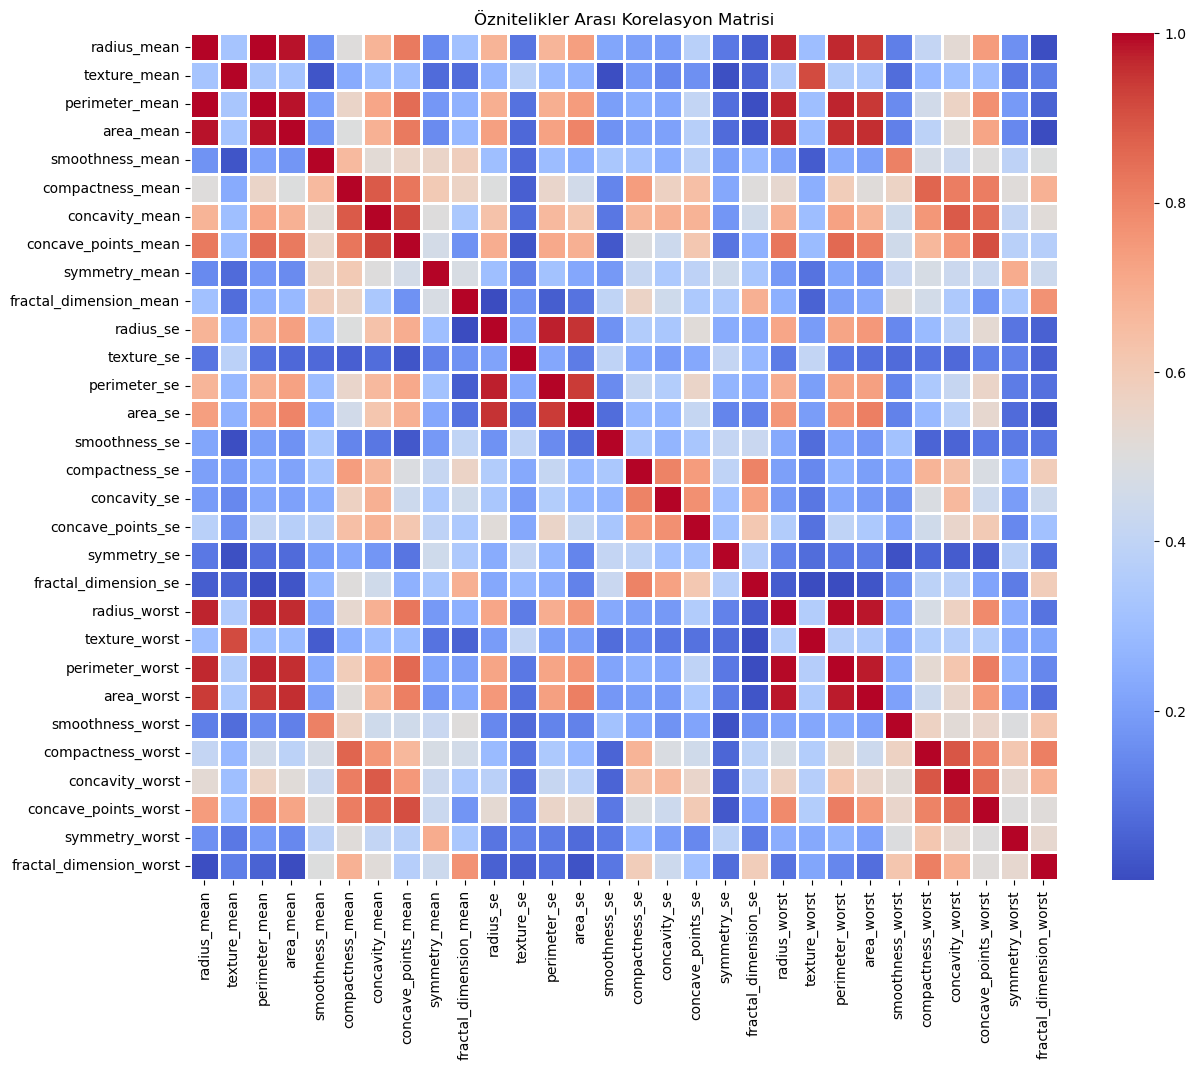

In [54]:
plt.figure(figsize=(14, 11))
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=1)
plt.title("Öznitelikler Arası Korelasyon Matrisi")
plt.show()


In [55]:
# X: giriş verisi, y: hedef sınıf (0 veya 1)
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]


In [56]:
# Eğitim %80, test %20 olacak şekilde ayırıyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
# Veriyi ölçeklendiriyoruz (standartlaştırma)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [58]:
# KNN sınıflandırıcısını tanımlıyoruz (k = 7 komşu)
knn = KNeighborsClassifier(n_neighbors=7)

# Modeli eğitiyoruz
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=7)

In [59]:
# Test verisinde tahmin yapıyoruz
y_pred = knn.predict(X_test)

# Doğruluk oranını hesaplıyoruz
print("Doğruluk Oranı: {:.6f}".format(accuracy_score(y_test, y_pred)))

# Sınıflandırma raporunu yazdırıyoruz
print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred))

# Karışıklık matrisi
cm = confusion_matrix(y_test, y_pred)
print("\nKarışıklık Matrisi:")
print(cm)


Doğruluk Oranı: 0.956140

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114


Karışıklık Matrisi:
[[68  3]
 [ 2 41]]


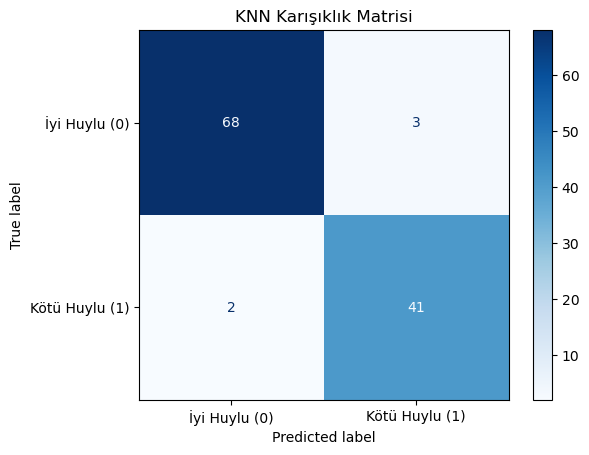

In [60]:
# Karışıklık matrisi çizimi (görsel)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["İyi Huylu (0)", "Kötü Huylu (1)"])
disp.plot(cmap="Blues")
plt.title("KNN Karışıklık Matrisi")
plt.show()


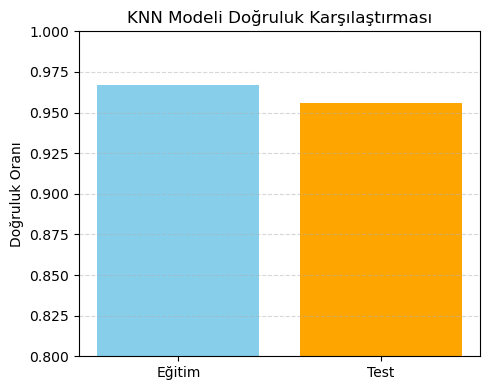

In [61]:
# Eğitim ve test doğrulukları karşılaştırılıyor
train_acc = knn.score(X_train, y_train)
test_acc = knn.score(X_test, y_test)

plt.figure(figsize=(5, 4))
plt.bar(["Eğitim", "Test"], [train_acc, test_acc], color=["skyblue", "orange"])
plt.title("KNN Modeli Doğruluk Karşılaştırması")
plt.ylabel("Doğruluk Oranı")
plt.ylim(0.8, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [62]:
# Özellikleri ve hedefi ayır
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

# Eğitim ve test kümelerine ayır
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ölçekleme işlemi
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


En uygun k değeri: 7
Bu değerdeki doğruluk: 0.9561


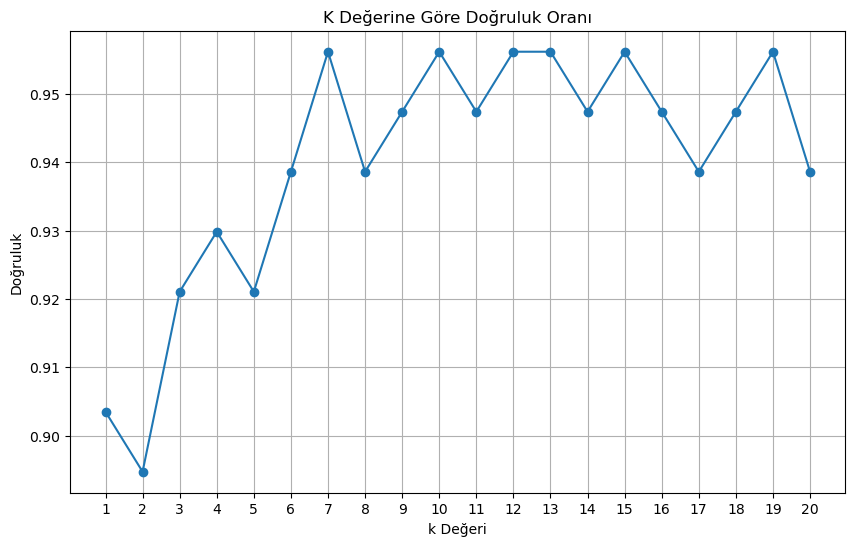

In [63]:

# En uygun k değerini belirlemek için farklı k değerlerini test et
k_range = range(1, 21)  # 1'den 20'ye kadar olan k değerlerini dene
accuracy_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

# En yüksek doğruluğu veren k değeri ve doğruluğu yazdır
best_k = k_range[np.argmax(accuracy_scores)]
best_accuracy = max(accuracy_scores)

print(f"En uygun k değeri: {best_k}")
print(f"Bu değerdeki doğruluk: {best_accuracy:.4f}")

# Grafikle görselleştir
plt.figure(figsize=(10,6))
plt.plot(k_range, accuracy_scores, marker='o')
plt.title("K Değerine Göre Doğruluk Oranı")
plt.xlabel("k Değeri")
plt.ylabel("Doğruluk")
plt.xticks(k_range)
plt.grid(True)
plt.show()


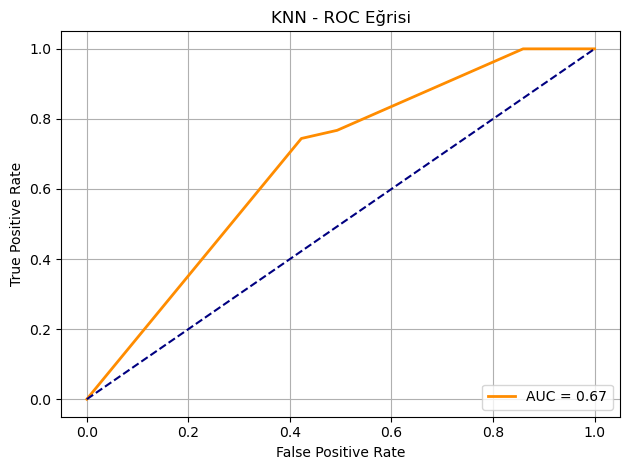

In [87]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC eğrisi için olasılık tahmini
y_proba = knn.predict_proba(X_test.values)[:, 1]  # Probabilities for the positive class

# ROC eğrisi verileri
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# ROC eğrisi çizimi

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Random classifier diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN - ROC Eğrisi")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
